<a href="https://colab.research.google.com/github/asutoshp10/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,Model
from keras.layers import *
from keras.optimizers import Adam

In [ ]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 3s 0us/step


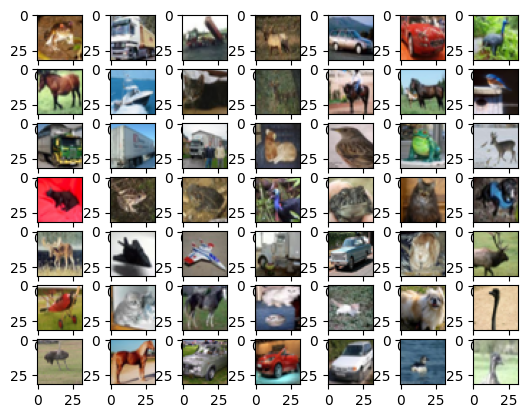

In [ ]:
(x_tr,y_tr),(x_test,y_test)=load_data()
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.imshow(x_tr[i])

In [ ]:
x_tr=(x_tr-127.5)/127.5

In [ ]:
def generate_real_data(dataset,items):
  a=np.random.randint(1,len(dataset),items)
  x=dataset[a]
  y=np.ones((items,1))
  return x,y

In [ ]:
x,y=generate_real_data(x_tr,10)
x.shape

(10, 32, 32, 3)

In [ ]:
def generate_fake_data(items):
  x=np.random.randn(items,32,32,3)
  x=x*2-1
  y=np.zeros((items,1))
  return x,y

In [ ]:
def discriminator(input_dims=(32,32,3)):
  model=Sequential()
  model.add(Conv2D(64,(3,3),padding='same',input_shape=input_dims))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,(3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,(3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256,(3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid',))

  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def train_discriminator(dataset,model,n_iter=20,batch_size=128):
  half=int(batch_size/2)
  for i in range(n_iter):
    x_real,y_real=generate_real_data(dataset,half)
    _,real_acc=model.train_on_batch(x_real,y_real)

    x_fake,y_fake=generate_fake_data(half)
    _,fake_acc=model.train_on_batch(x_fake,y_fake)

    print(f'{i+1} Real_accuracy:{real_acc}  Fake_accuracy:{fake_acc}')

In [ ]:
model=discriminator()
train_discriminator(x_tr,model)

1 Real_accuracy:0.84375  Fake_accuracy:0.0
2 Real_accuracy:1.0  Fake_accuracy:0.640625
3 Real_accuracy:0.390625  Fake_accuracy:1.0
4 Real_accuracy:0.3125  Fake_accuracy:1.0
5 Real_accuracy:0.5625  Fake_accuracy:1.0
6 Real_accuracy:0.75  Fake_accuracy:1.0
7 Real_accuracy:0.953125  Fake_accuracy:1.0
8 Real_accuracy:0.921875  Fake_accuracy:1.0
9 Real_accuracy:0.953125  Fake_accuracy:1.0
10 Real_accuracy:0.984375  Fake_accuracy:1.0
11 Real_accuracy:0.953125  Fake_accuracy:1.0
12 Real_accuracy:0.984375  Fake_accuracy:1.0
13 Real_accuracy:1.0  Fake_accuracy:1.0
14 Real_accuracy:1.0  Fake_accuracy:1.0
15 Real_accuracy:1.0  Fake_accuracy:1.0
16 Real_accuracy:1.0  Fake_accuracy:1.0
17 Real_accuracy:0.984375  Fake_accuracy:1.0
18 Real_accuracy:1.0  Fake_accuracy:1.0
19 Real_accuracy:0.90625  Fake_accuracy:1.0
20 Real_accuracy:1.0  Fake_accuracy:1.0


In [ ]:
def generator(latent_dim=100):
  n_nodes=4*4*256
  model=Sequential()
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
  return model

In [ ]:
def generate_latent_dim(latent_dim,items):
  x=np.random.randn(items,latent_dim)
  return x

In [ ]:
def generate_fake_data2(g_model,latent_dim,items):
  l=generate_latent_dim(latent_dim,items)
  x=g_model.predict(l)
  y=np.zeros((items,1))
  return x,y

In [ ]:
def gan(g_model,d_model):
  d_model.trainable=False
  model=Sequential()
  model.add(g_model)
  model.add(d_model)
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def train(g_model,d_model,gan_model,dataset,n_epochs=200,batch_size=128,latent_dim=100):
  half=int(batch_size/2)
  bat_per_epoch=int(len(dataset)/batch_size)
  for i in range(n_epochs):
    for j in range(bat_per_epoch):
      x_real,y_real=generate_real_data(dataset,half)
      d_loss1,d_acc1=d_model.train_on_batch(x_real,y_real)

      x_fake,y_fake=generate_fake_data2(g_model,latent_dim,half)
      d_loss2,d_acc2=d_model.train_on_batch(x_fake,y_fake)

      x_gan=generate_latent_dim(latent_dim,batch_size)
      y_gan=np.ones((batch_size,1))

      g_loss=gan_model.train_on_batch(x_gan,y_gan)
      print(f'{i+1} {j+1} {d_loss1} {d_loss2} {g_loss}')

    if (i+1)%10==0:
      summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [ ]:
def summarize_performance(epoch_no,g_model,d_model,dataset,latent_dim,n_samples=150):
  x_real,y_real=generate_real_data(dataset,n_samples)
  _,acc_real=d_model.evaluate(x_real,y_real,verbose=0)

  x_fake,y_fake=generate_fake_data2(g_model,latent_dim,n_samples)
  _,acc_fake=d_model.evaluate(x_fake,y_fake,verbose=0)

  print(f'Epoch_no:{epoch_no}  Real_accuracy:{acc_real}  Fake_accuracy:{acc_fake}')

  save_plot(x_fake,epoch_no)

  file_name=f'generator_model{i+1}'
  g_model.save(file_name)

In [ ]:
def save_plot(x_fake,epoch_no,n=7):
  x_fake=(x_fake+1)/2
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.axis='off'
    plt.imshow(x_fake[i])

  filename=f'generated_image{epoch_no+1}'
  plt.savefig(filename)
  plt.close()

In [1]:
g_model=generator()
d_model=discriminator()
gan_model=gan(g_model,d_model)
train(g_model,d_model,gan_model,x_tr)